# <font color = 'red'> Strategy </font>
### Bollinger bands are comprised of a simple moving average along with upper and lower bands (typically 2 STDDEV away). The bands widen and narrow as the volatility of the underlying asset changes. 

# <font color = 'red'> Configuration </font>

In [1]:
!pip3 install ta

# <font color = 'red'> Indicator Imports </font>

In [3]:
#Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

# <font color = 'red'> MAANG stocks and Period</font>

In [39]:
meta = 'META'
amazon = "AMZN"
apple = "AAPL"
netflix = 'NFLX'
google = 'GOOGL'

stockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
stockData = {}
weight = 0.2

start = '2015-01-01'
end = '2019-12-31'

# <font color = 'red'> Plot graphs for stocklist to check</font>

Text(0.5, 1.0, 'stock close price')

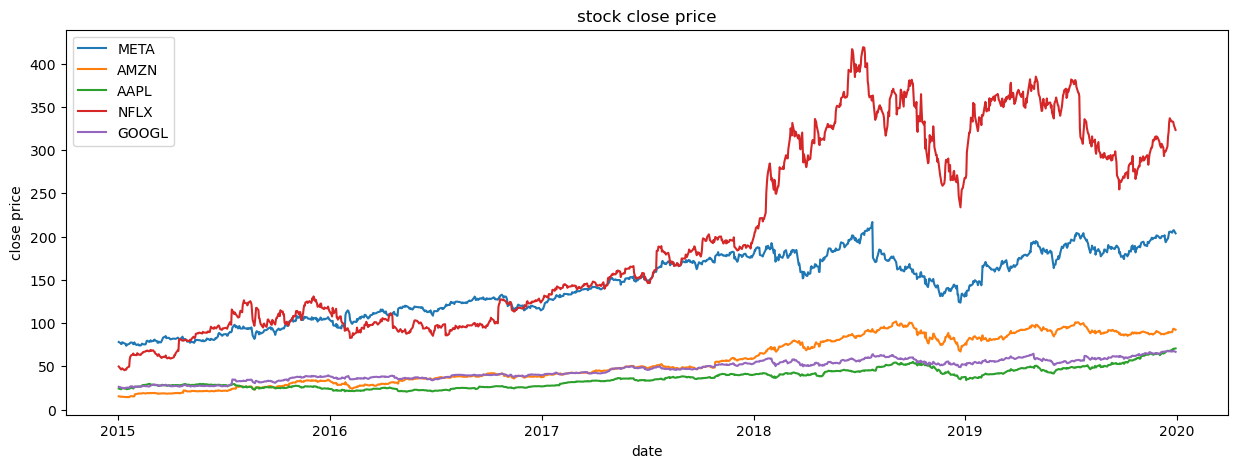

In [40]:
fig = plt.figure(figsize=(15, 5))
for stock in stockList.keys():
	hist_stock = yf.Ticker(stock).history(start = start, end = end)
	stockList[stock]['info'] = hist_stock
	plt.plot(hist_stock.index, hist_stock['Close'], label=f"{stock}")
	plt.legend()

plt.xlabel('date')
plt.ylabel('close price')
plt.title(f'stock close price')

<hr>

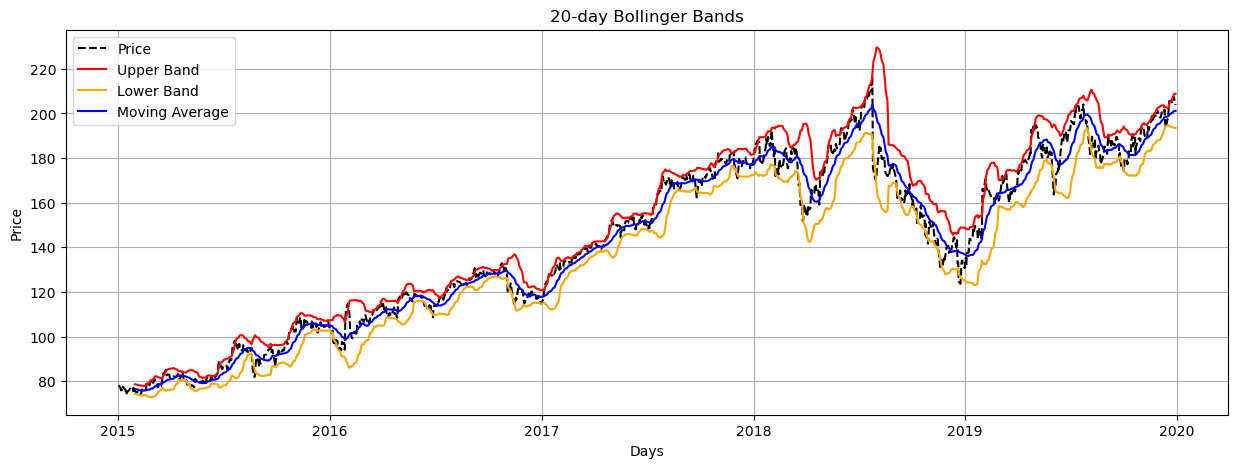

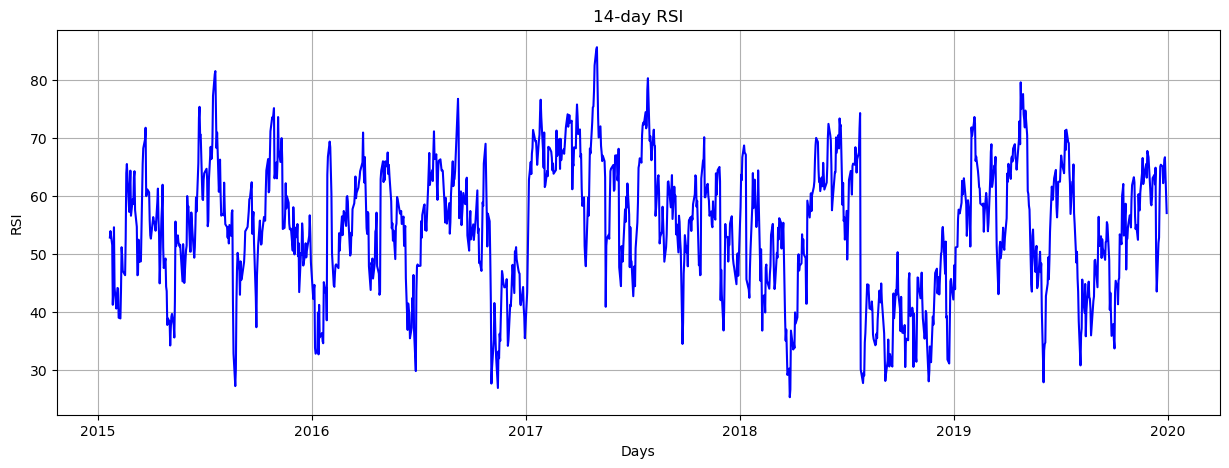

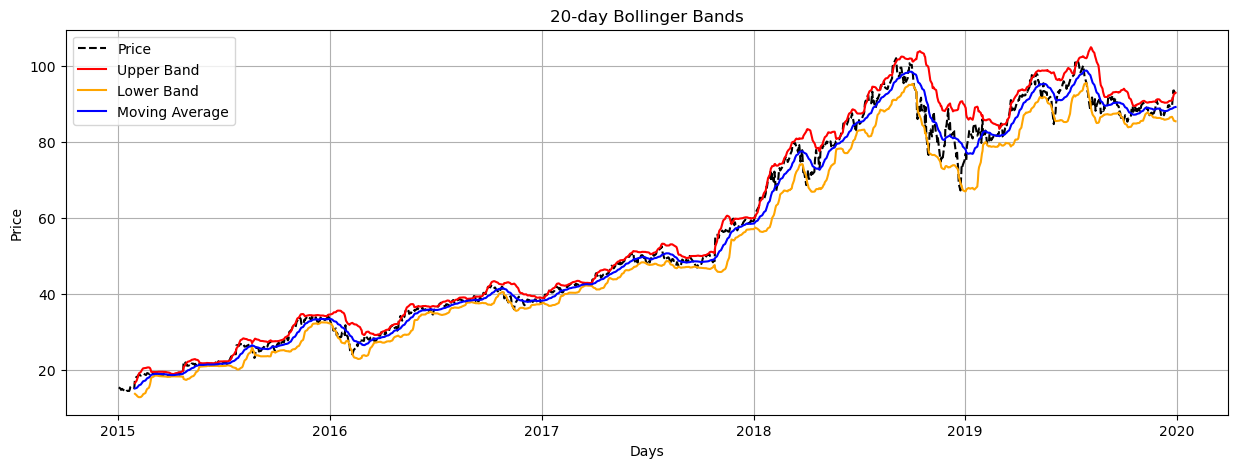

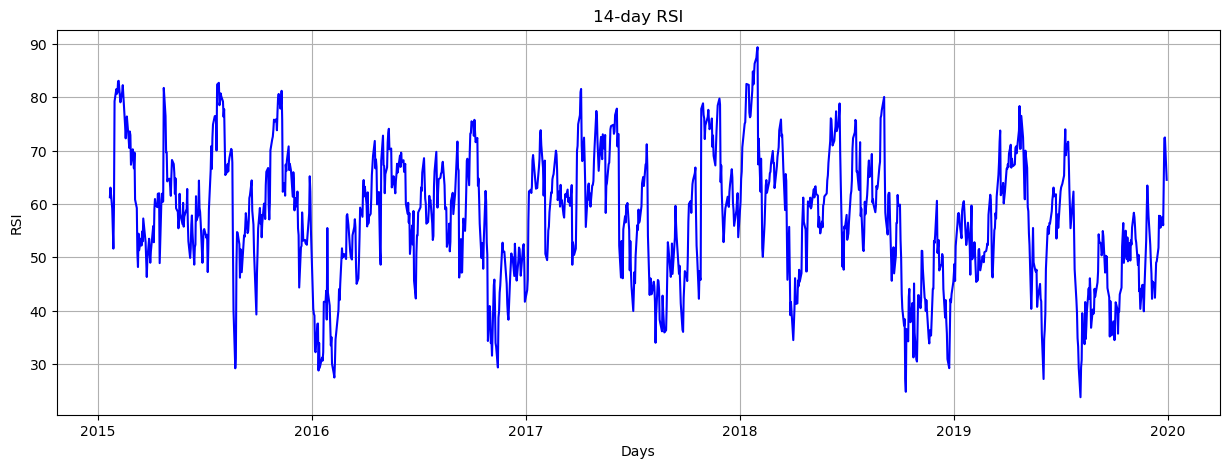

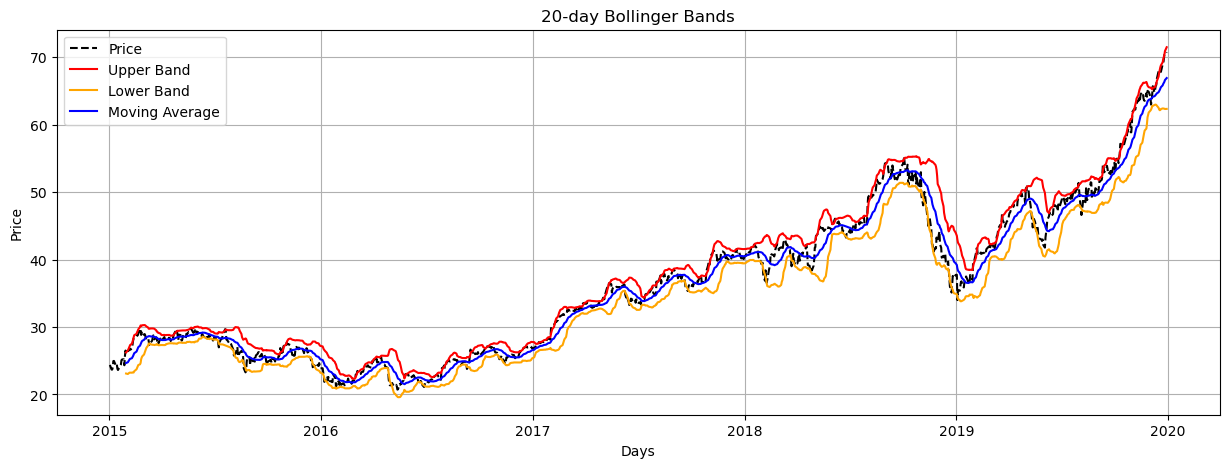

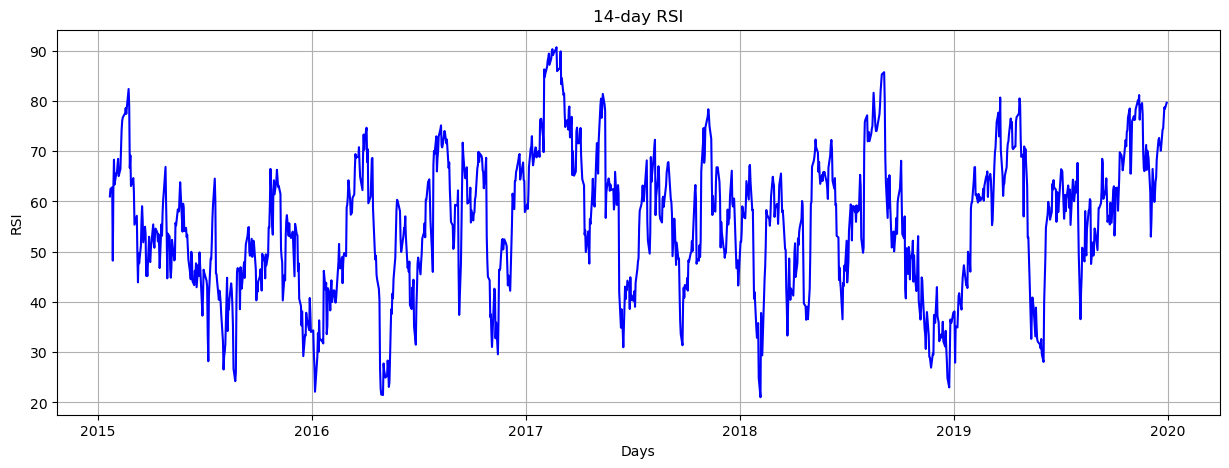

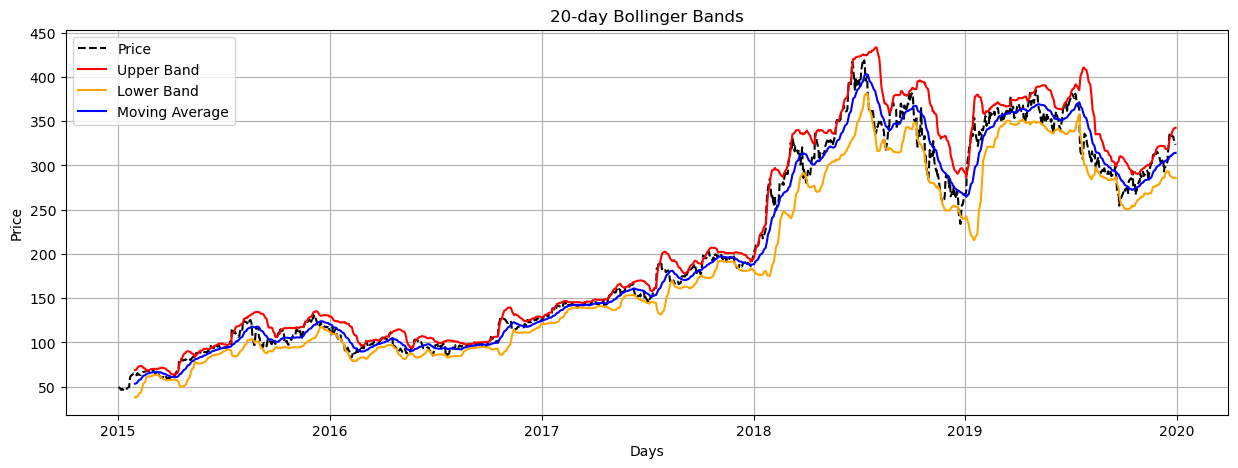

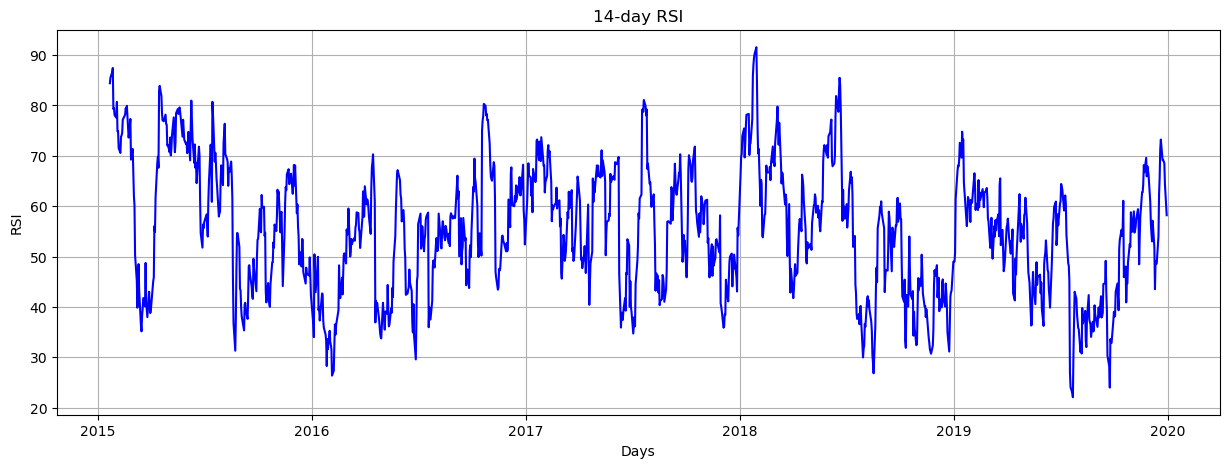

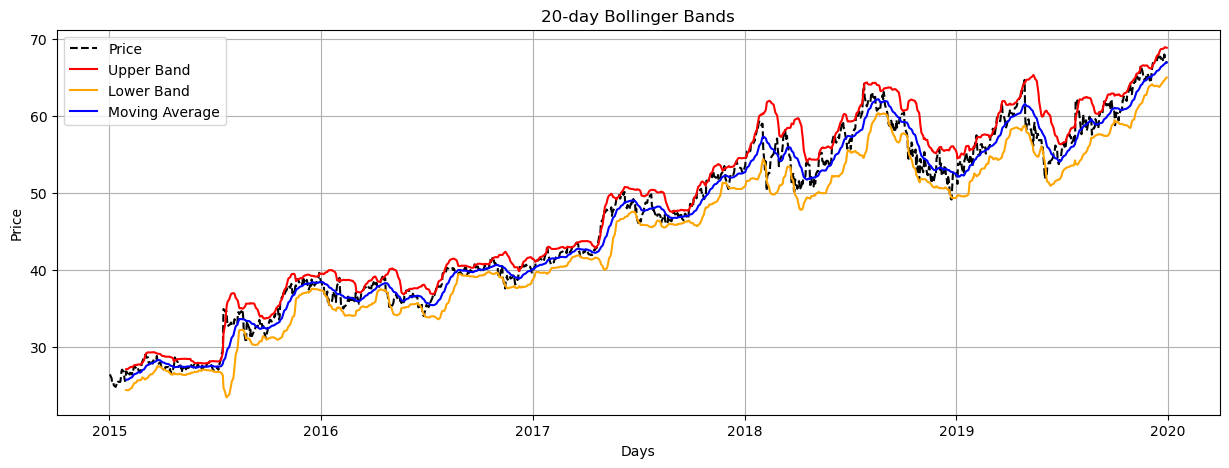

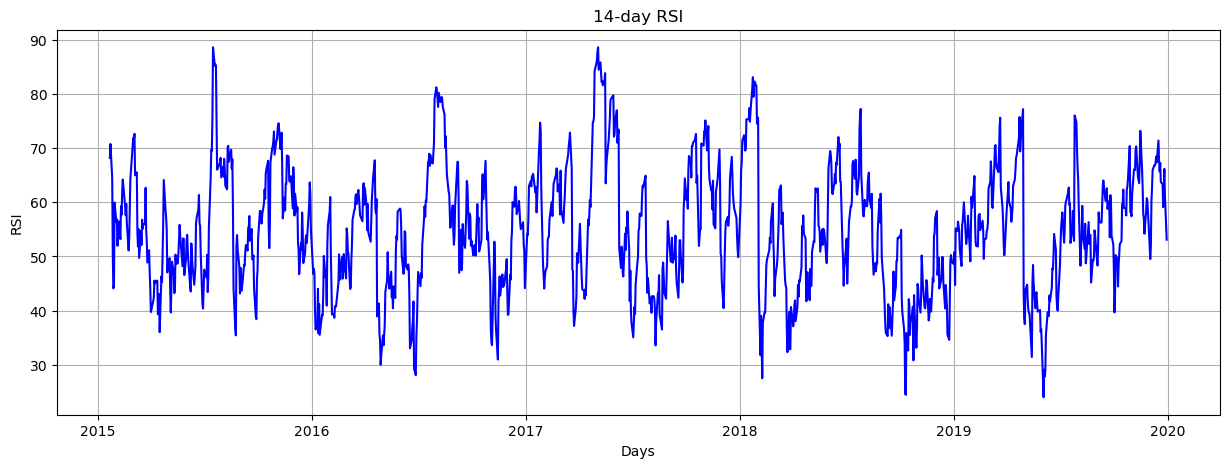

In [41]:
## change window for RSI  and bb

bbwindow = 20
rsiwindow = 14

for stock in stockList.keys():
    bollingerbands = BollingerBands(close=stockList[stock]['info']["Close"], window=bbwindow, fillna=False)
    stockList[stock]['bb'] = {} # store bb
    stockList[stock]['bb']['high'] = bollingerbands.bollinger_hband()
    stockList[stock]['bb']['low'] = bollingerbands.bollinger_lband()
    stockList[stock]['bb']['mid'] = bollingerbands.bollinger_mavg() 

    rsi = RSIIndicator(close=stockList[stock]['info']["Close"], window=rsiwindow, fillna=False)
    rsiValue = rsi.rsi()
    stockList[stock]['rsi'] = {}
    stockList[stock]['rsi']['rsiValue'] = rsiValue

    ## was gna attempt roc for momentum
    roc = ROCIndicator(close=stockList[stock]['info']["Close"], window=5)
    rocValue = roc.roc()
    stockList[stock]['roc'] = {}
    stockList[stock]['roc']['rocValue'] = rocValue

    # Calculate 50-day SMA for stop loss
    # sma_50 = SMAIndicator(close=stockList[stock]["Close"], window=80, fillna=False).sma_indicator()

    # Calculate ATR (e.g., 14-period ATR)
    #atr = AverageTrueRange(
    #    high=stockList[stock]["High"], 
    #    low=stockList[stock]["Low"], 
    #    close=stockList[stock]["Close"], 
    #    window=14, 
    #    fillna=False
    #).average_true_range()

    plt.figure(figsize=(15, 5))
    plt.plot(stockList[stock]['info']["Close"], color='black', label='Price', linestyle='dashed')
    plt.plot(stockList[stock]['bb']['high'], color='red', label='Upper Band')
    plt.plot(stockList[stock]['bb']['low'], color='orange', label='Lower Band')
    plt.plot(stockList[stock]['bb']['mid'], color='blue', label='Moving Average')

    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title(f"{bbwindow}-day Bollinger Bands")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(rsiValue, color='blue', label='RSI')
    plt.xlabel("Days")
    plt.ylabel("RSI")
    plt.title(f"{rsiwindow}-day RSI")
    plt.grid()
    plt.show()

# <font color = 'red'> Momentum + Volatility + Trend </font>
Bollinger Bands
Long Signals
1. close touch bottom band

Short Signal
1. close touch top band

ROC --> adding more momentum... but 3 indicators...

RSI
Long Signals
1. Below 30 --> undersold

Short Signals
2. Above 70 --> overbought

# <font color = 'red'> Determine Position Based on Signals, Individually </font>

In [42]:
for stock in stockList.keys():	
	## bb signals
	# if close price is out of bands, consider positions accordingly
	bb_sell  = np.where(np.array(stockList[stock]['bb']['high']) < np.array(stockList[stock]['info']["Close"]), -1, 0)
	bb_buy = np.where(np.array(stockList[stock]['bb']['low']) > np.array(stockList[stock]['info']["Close"]), 1, 0)
	bb_pos = bb_sell + bb_buy
	stockList[stock]['bb']['pos'] = bb_pos

	## rsi signal
	# if out of rsi 70 and 30 values, consider positions accordingly
	rsi_pos = np.array(list(map(lambda x: -1 if x > 70 else (1 if x < 30 else 0), stockList[stock]['rsi']['rsiValue'])))
	stockList[stock]['rsi']['pos'] = rsi_pos

## stop loss using 50 day MA --> to be implemented?


# <font color = 'red'> Merge positions together from different indicators </font>

# Possible tuning opportunities
rsi try w roc as momentum 
      										BB
						x < Lower | lower <= x <= higher | x > higher
	x < 30			|		Buy				Buy					X
RSI 30 <= x <= 70 	|		Buy				 X					X
	x > 70			|		 X				Sell			   Sell

In [43]:
## Stop Loss Function (WIP) --> performs worse...
def apply_atr_stop_loss(position, close_price, atr, atr_multiplier=2):
    updated_position = []
    stop_loss_level = None  # To track stop loss level based on ATR

    for i in range(len(position)):
        if position[i] == 1:  # Long position
            if stop_loss_level is None:
                # Set stop loss level at the time of entering the long position
                stop_loss_level = close_price[i] - atr_multiplier * atr[i]
                updated_position.append(position[i])  # Continue holding long

            elif close_price[i] < stop_loss_level:  # Trigger stop loss for long
                updated_position.append(-1)  # Exit long position
                stop_loss_level = None  # Reset stop loss after exit
            else:
                updated_position.append(position[i])  # Continue holding long

        elif position[i] == -1:  # Short position
            if stop_loss_level is None:
                # Set stop loss level at the time of entering the short position
                stop_loss_level = close_price[i] + atr_multiplier * atr[i]
                updated_position.append(position[i])  # Continue holding long

            elif close_price[i] > stop_loss_level:  # Trigger stop loss for short
                updated_position.append(1)  # Exit short position
                stop_loss_level = None  # Reset stop loss after exit
            else:
                updated_position.append(position[i])  # Continue holding short

        else:
            updated_position.append(position[i])  # No position
            stop_loss_level = None  # Reset stop loss when no position is held

    return updated_position


## Convert to Position because curr is 1, 0, -1 but shld be 1 and -1 (acc to lecture slide) **** weird
def convertToPosition(series, num):
    series = list(series)
    ls = []
    temp = 0
    for ele in series:
        if ele == num or ele == -num:
            ls.append(int(ele/num))
            temp = int(ele/num)
        else:
            ls.append(temp)
    return ls


## Combine RSI and BB Signals --> consider 3 by 3 matrix with row: rsi, col: bb
def combineSignals(bb_pos, rsi_pos):
    ## long conditions
    condition_1 = (1, 1)  # rsi < 30, bb < low
    condition_2 = (0, 1)  # 30 <= rsi <= 70, bb < low
    condition_3 = (1, 0)  # rsi < 30, low < bb < high

    ## short conditions
    condition_4 = (-1, 0)  # rsi > 70, low < bb < high
    condition_5 = (-1, -1) # rsi > 70, bb > high

    ls = []

    for index in range(len(bb_pos)):
        bb_signal = bb_pos[index]
        rsi_signal = rsi_pos[index]
        condition = (rsi_signal, bb_signal)

        if condition in [condition_1, condition_2, condition_3]:
        # if condition in [condition_1]: ## Polar version
            ls.append(1)  # Long position
        elif condition in [condition_4, condition_5]:
        # elif condition in [condition_5]: ## polar version
            ls.append(-1)  # Short position
        else:
            ls.append(0)  # No position

    return ls

for stock in stockList:
    # Combine signals
    signal = combineSignals(list(stockList[stock]['bb']['pos']), list(stockList[stock]['rsi']['pos']))
    stockList[stock]['roc']['rocValue']
    # Convert to position
    position = convertToPosition(signal, 1)

    stockList[stock]['position'] = position

    # Apply ATR-based stop loss --> WIP
    #atr_multiplier = 2  # Adjust this multiplier to control stop loss distance
    #final_position = apply_atr_stop_loss(position, stockData[netflix]["Close"], atr, atr_multiplier)

# <font color = 'red'> Prepare dataframe for graphing </font>

In [44]:
for stock in stockList:
	bt_data = pd.DataFrame()
	bt_data['close price'] = stockList[stock]['info']["Close"]
	bt_data['high band'] = stockList[stock]['bb']['high']
	bt_data['mid band'] = stockList[stock]['bb']['mid']
	bt_data['low band'] = stockList[stock]['bb']['low']
	bt_data['rsi value'] = stockList[stock]['rsi']['rsiValue']
	bt_data['position'] = stockList[stock]['position']
	bt_data["signal"] = bt_data['position'].diff()
	stockList[stock]['backtest'] = {}
	stockList[stock]['backtest']['data'] = bt_data

	bt_data.dropna(inplace = True)
	bt_data.head(10)

# <font color = 'red'> Graphing Buy and Sell signals </font>

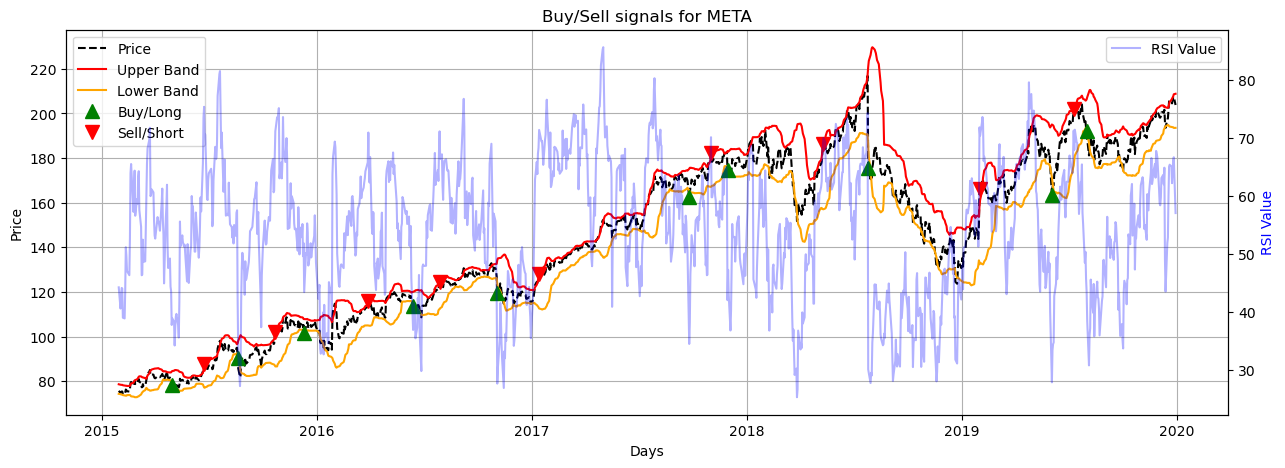

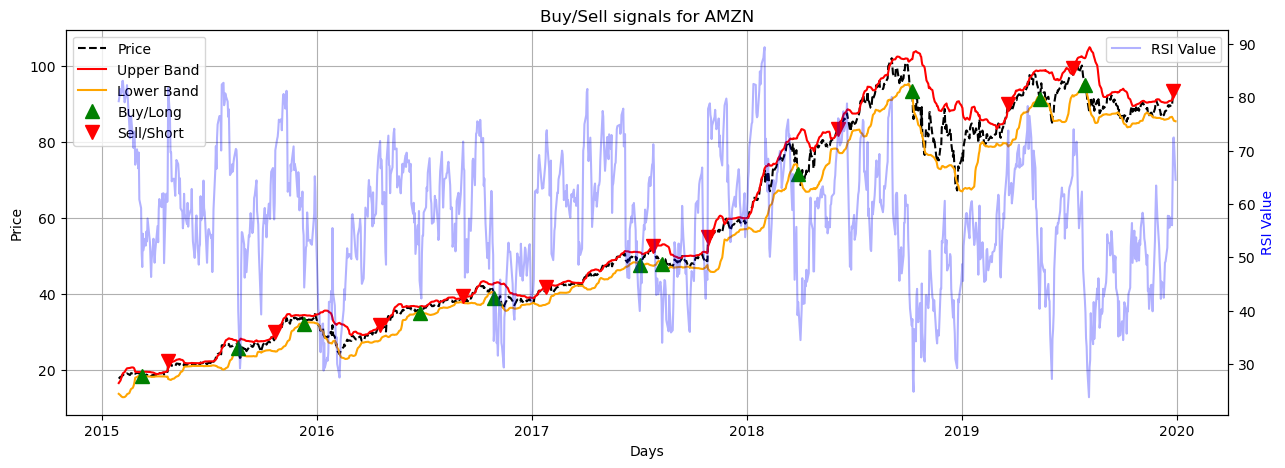

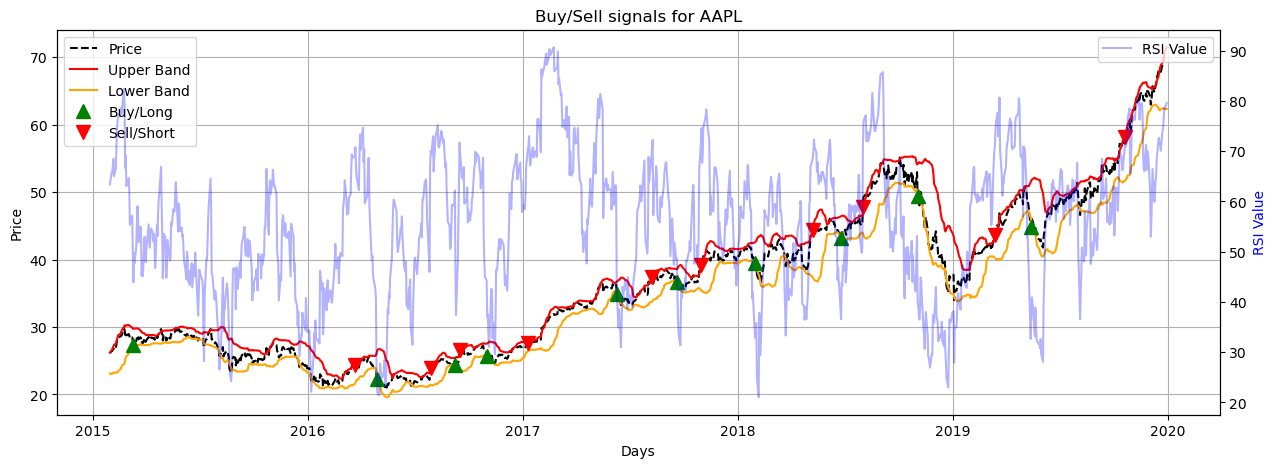

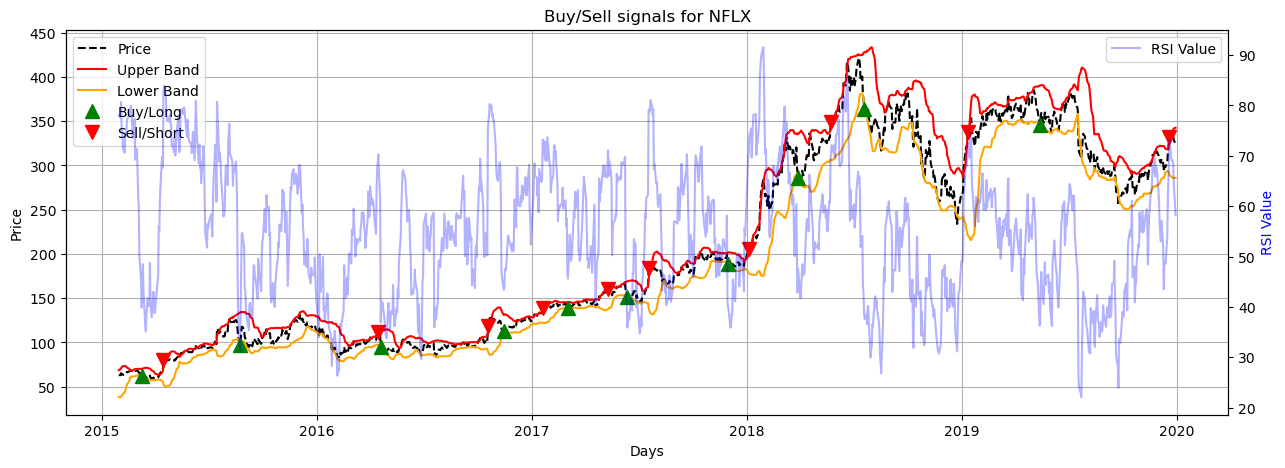

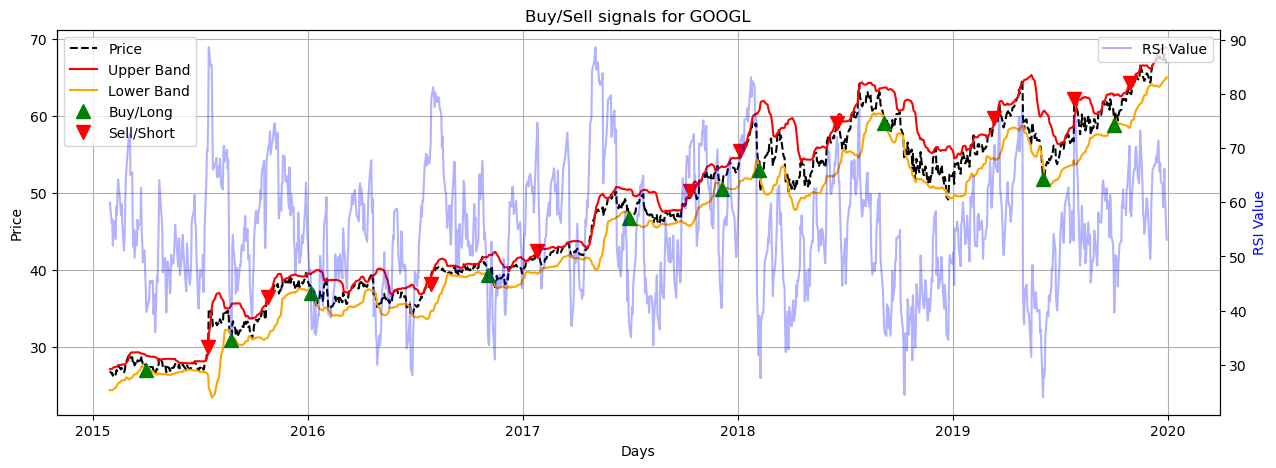

In [45]:
for stock in stockList:
    bt_data = stockList[stock]['backtest']['data']
    fig, ax1 = plt.subplots(figsize=(15, 5))

    ax1.plot(bt_data["close price"], color='black', label='Price', linestyle='dashed')
    ax1.plot(bt_data['high band'], color='red', label='Upper Band')
    ax1.plot(bt_data['low band'], color='orange', label='Lower Band')
    # ax1.plot(bt_data['mid band'], color='blue', label='Moving Average')
    
    ax1.plot(bt_data[bt_data['signal'] == 2].index,
             bt_data['close price'][bt_data['signal'] == 2],
             '^', markersize=10, color='g', label='Buy/Long')
    
    ax1.plot(bt_data[bt_data['signal'] == -2].index,
             bt_data['close price'][bt_data['signal'] == -2],
             'v', markersize=10, color='r', label='Sell/Short')

    ax1.set_xlabel("Days")
    ax1.set_ylabel("Price")
    
    ax2 = ax1.twinx()
    ax2.plot(bt_data['rsi value'], color='blue', label='RSI Value', alpha = 0.3)
    ax2.set_ylabel('RSI Value', color='blue')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Buy/Sell signals for {stock}')
    ax1.grid()
    plt.show()

# <font color = 'red'> Visualizing buy and sell position </font>

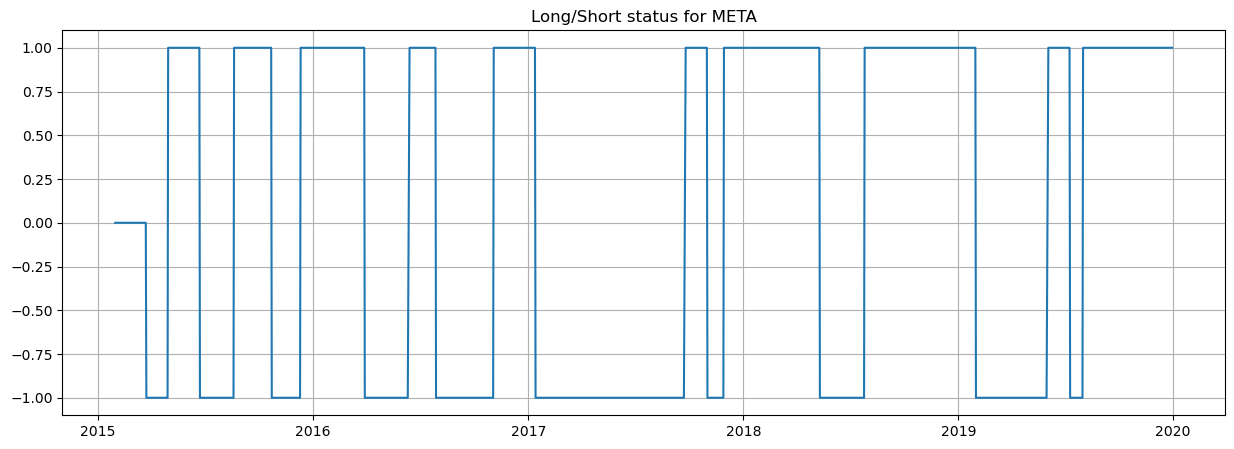

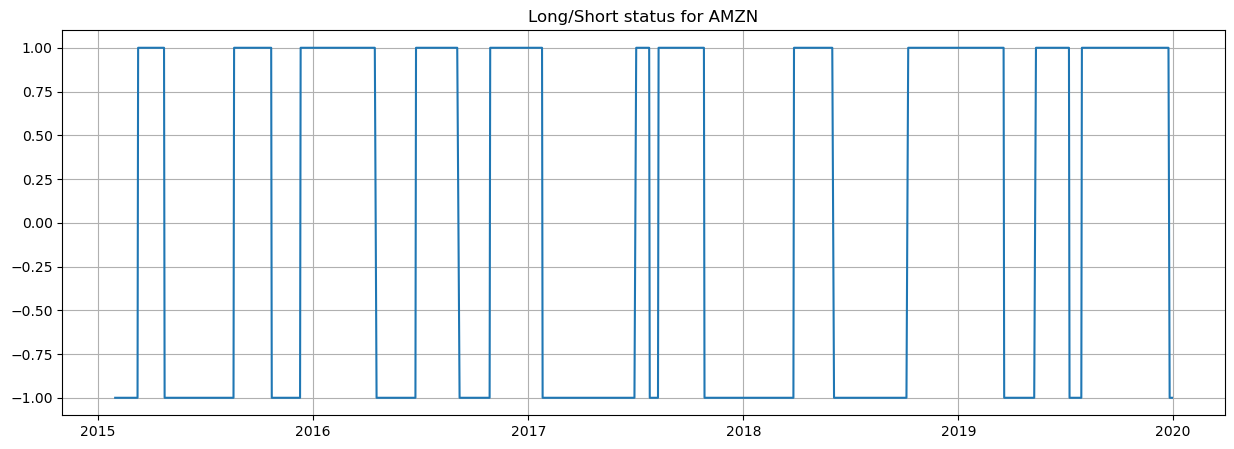

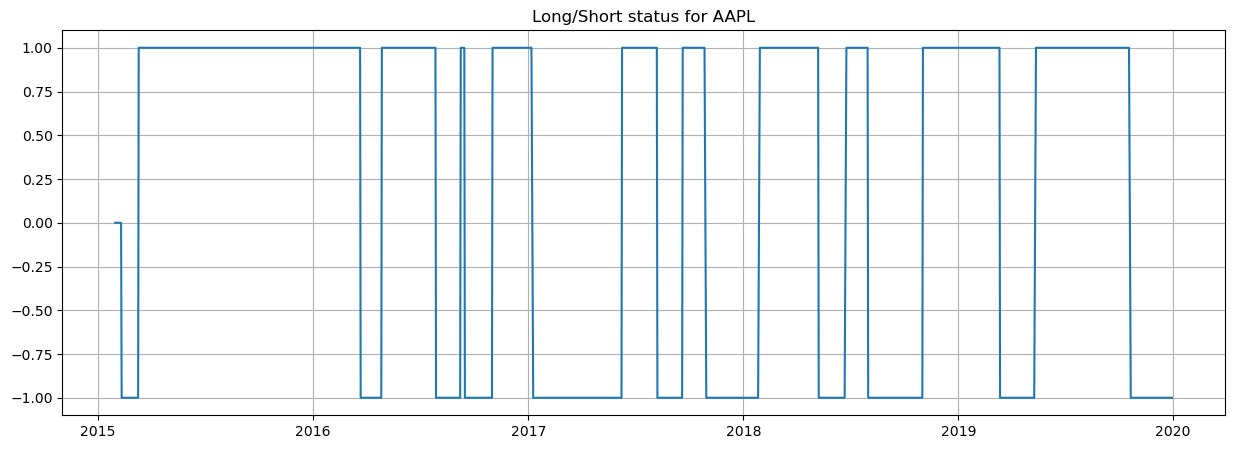

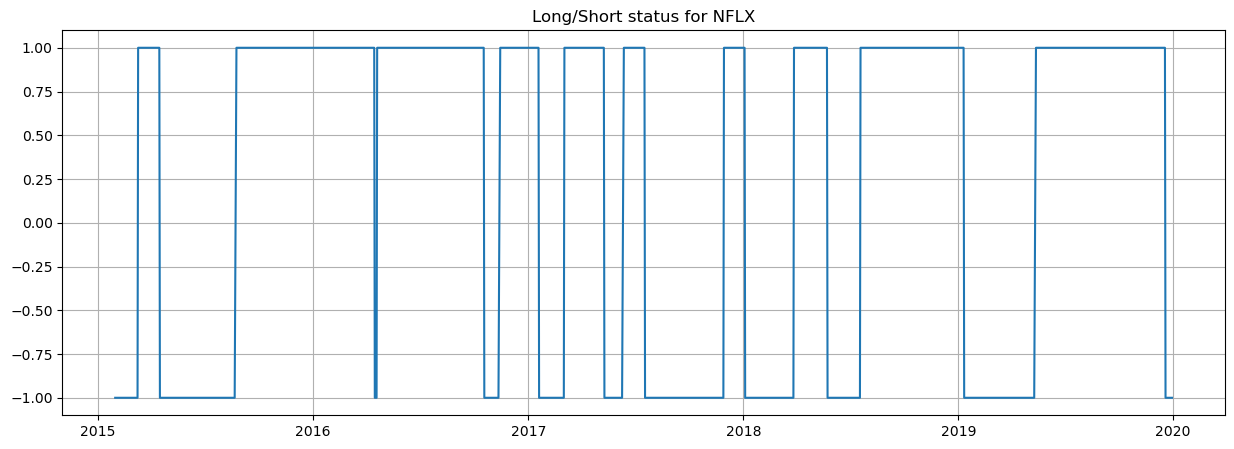

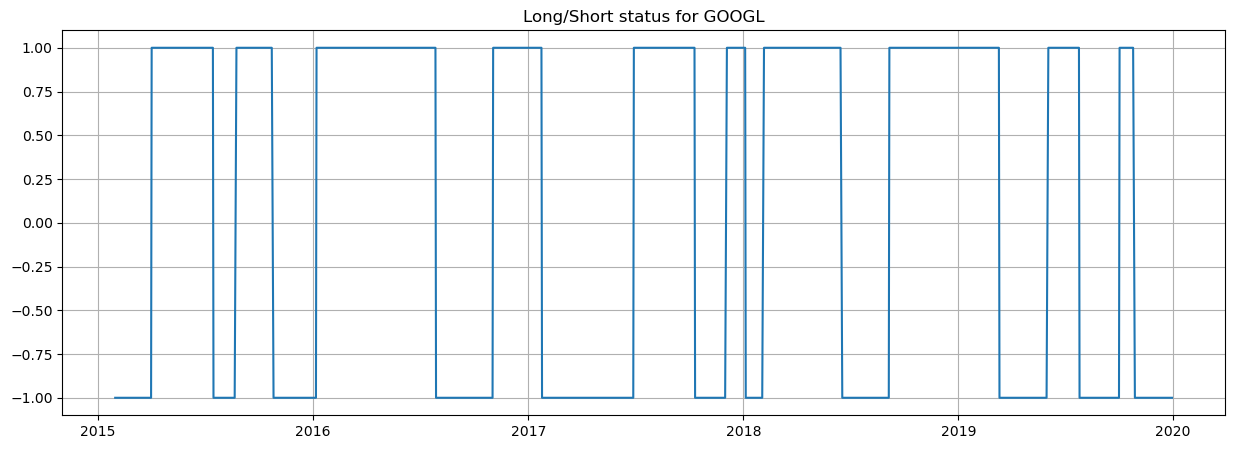

In [46]:
for stock in stockList:
	bt_data = stockList[stock]['backtest']['data']
	plt.figure(figsize=(15, 5))
	plt.plot(bt_data["position"])
	plt.title(f"Long/Short status for {stock}")
	plt.grid()
	plt.show()

# <font color = 'red'>Assess performance of strategy </font>

In [47]:
'''For easier calculations:
   You can carry out the analysis using daily regular returns assuming the returns are normal.
   However, I am using Daily Log Returns to demo the calculations.
'''

'''
# using shift() gives us the previous values
# Remember , These returns are the returns of the 'stock'.
# That is if you were invested all the time in the stock
# We are using log returns as they are additive. We cant simply add regular or aritmetic returns.
# Arithmetic /Regular returns are limited to  0 on the downside.
# Adding all the daily log returns will give us the overall gross returns.
# Log returns are normally distributed and we can perform calculations.
'''
for stock in stockList:
   bt_data = stockList[stock]['backtest']['data']
   bt_data['stock returns'] = np.log(bt_data["close price"] / bt_data["close price"].shift(1))
   bt_data.head(10)

# <font color = 'red'>Graphing stock return vs strategy returns </font>

0.9905793363705893
Stock returns are 0.9905793363705889 for META
Strategy returns are 0.9520891195508281 for META
--------------------------


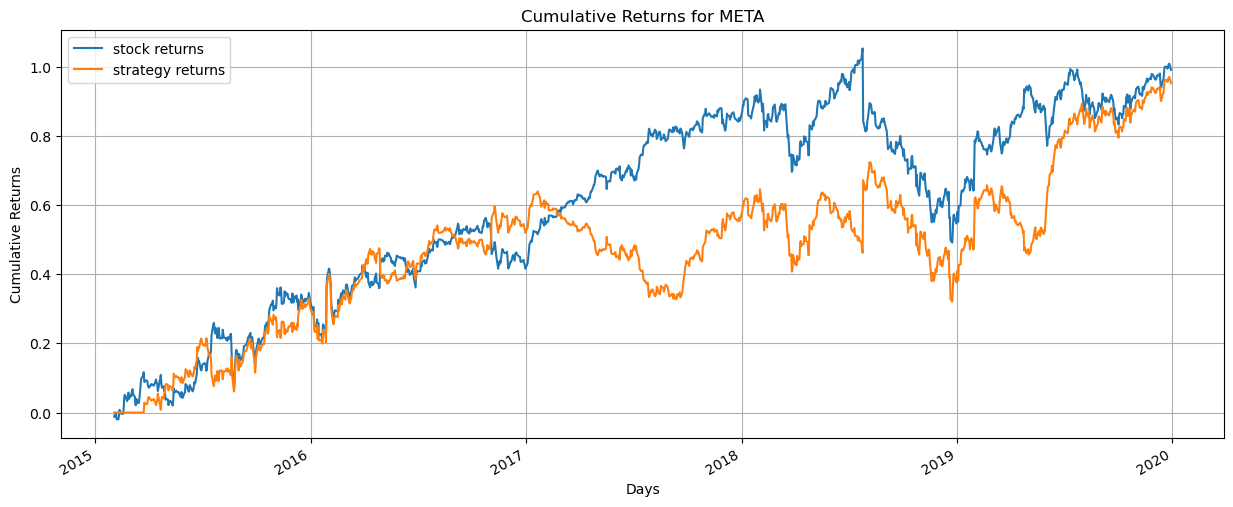

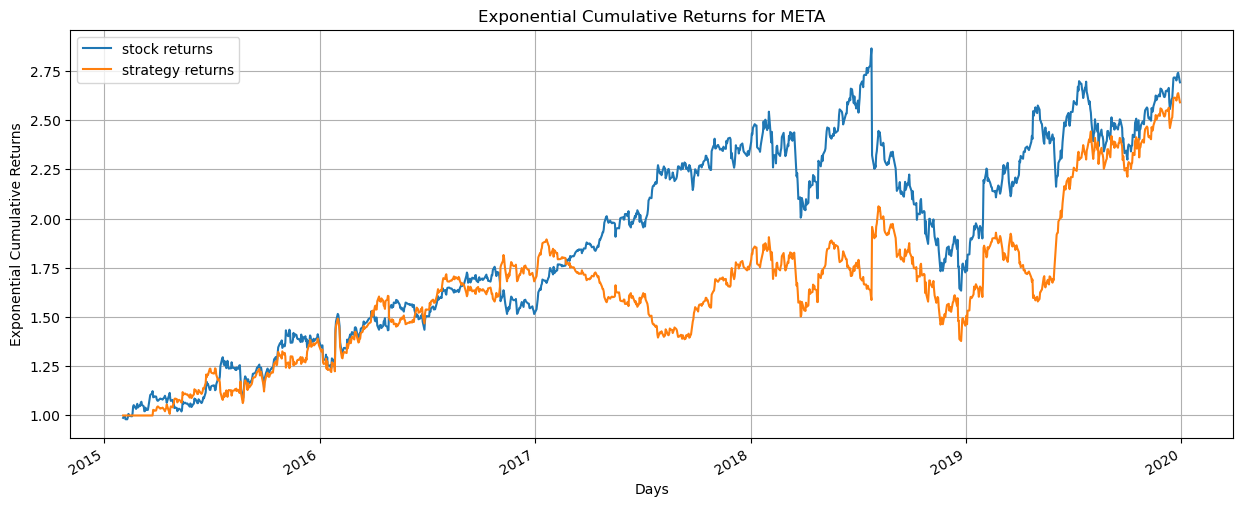

1.6504654536099532
Stock returns are 1.650465453609953 for AMZN
Strategy returns are 0.24721777620053603 for AMZN
--------------------------


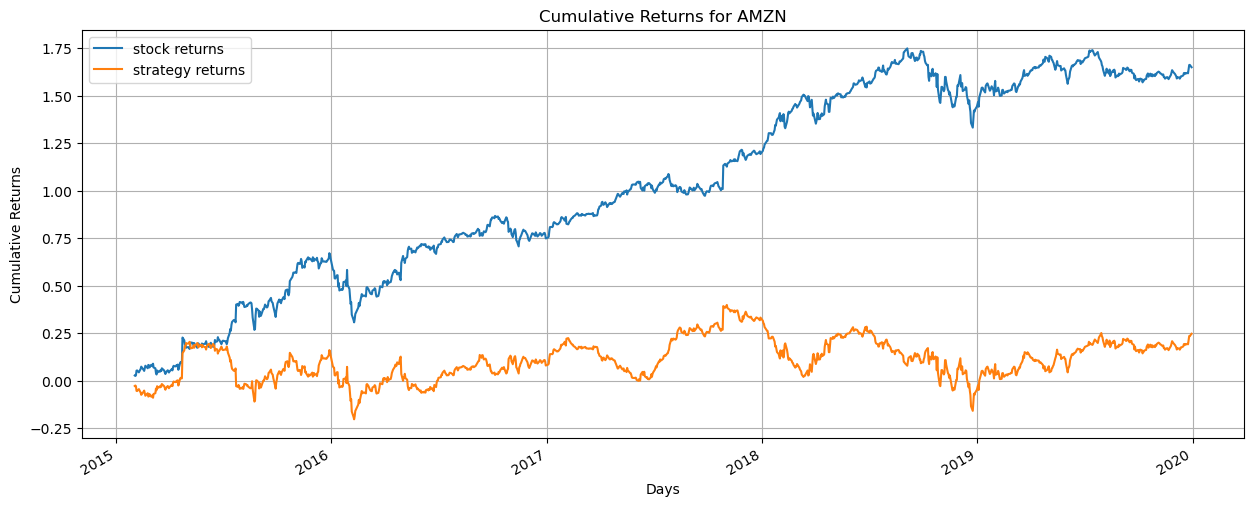

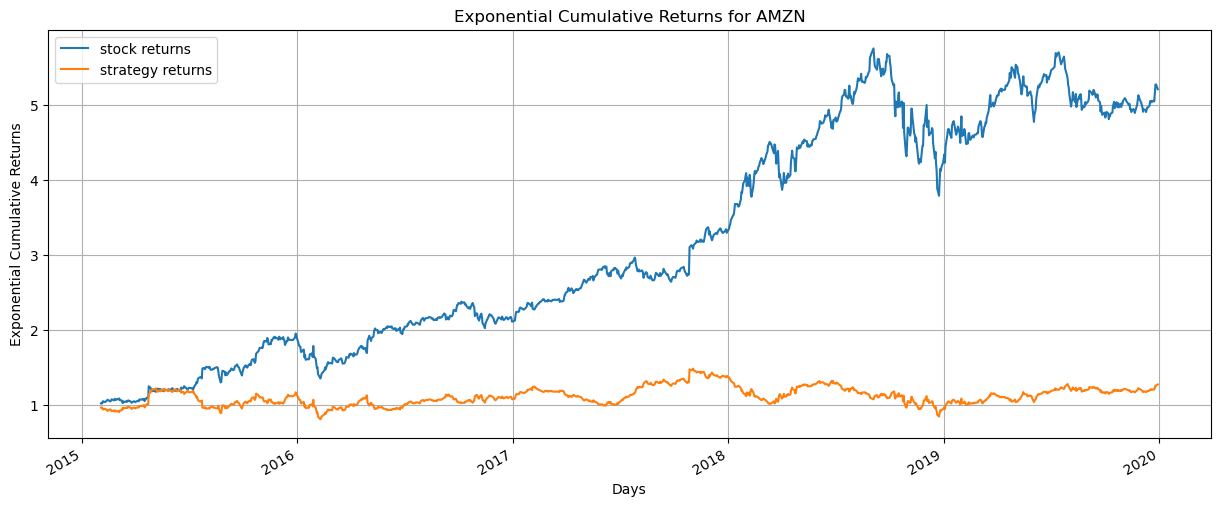

0.9962362222654448
Stock returns are 0.9962362222654462 for AAPL
Strategy returns are 0.2562204815486745 for AAPL
--------------------------


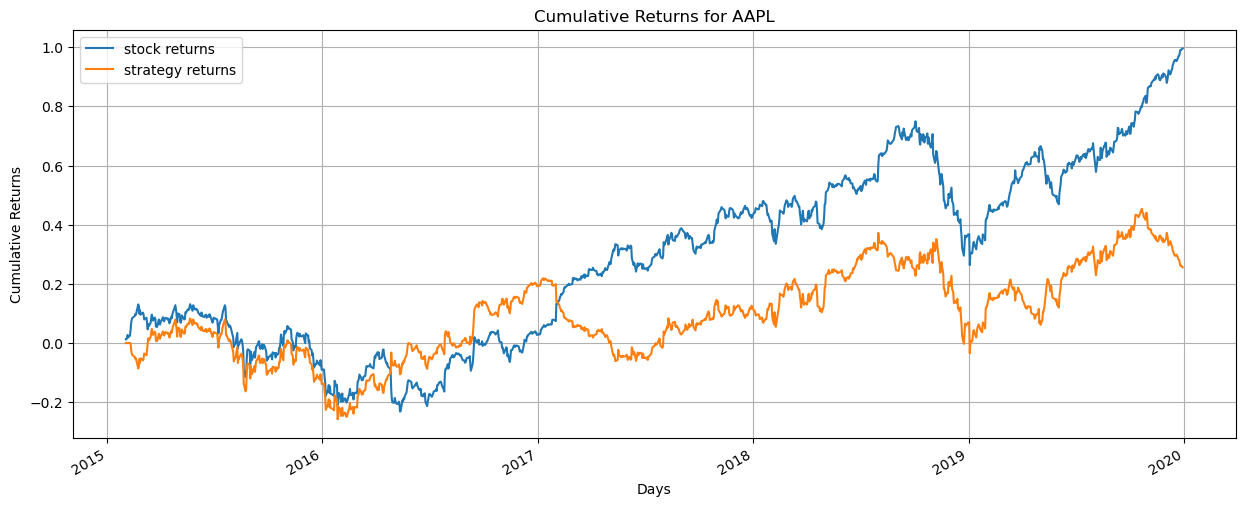

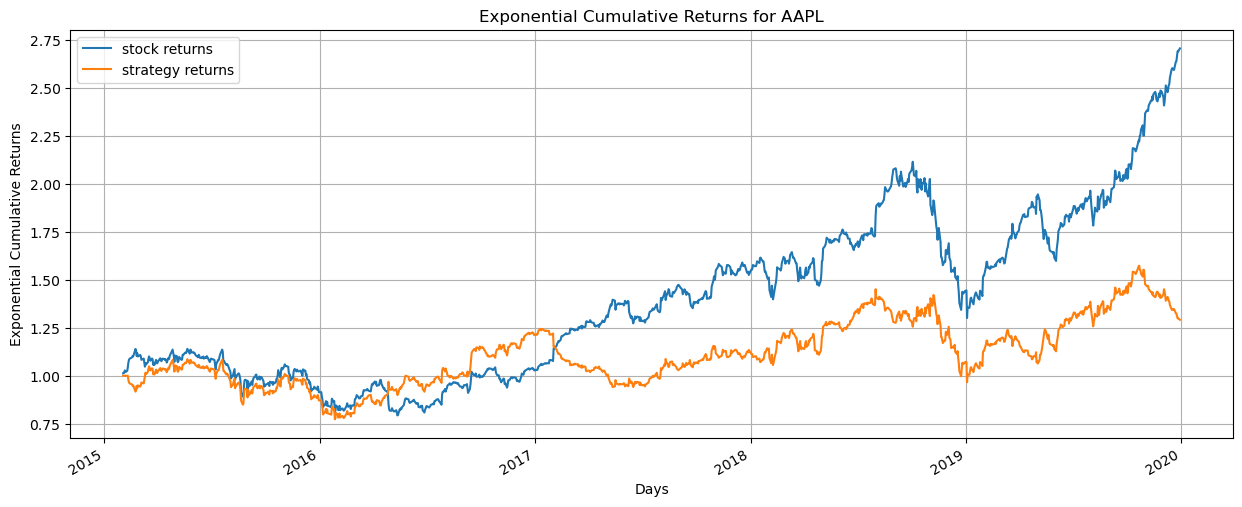

1.6336644847906365
Stock returns are 1.6336644847906372 for NFLX
Strategy returns are 1.037910496926667 for NFLX
--------------------------


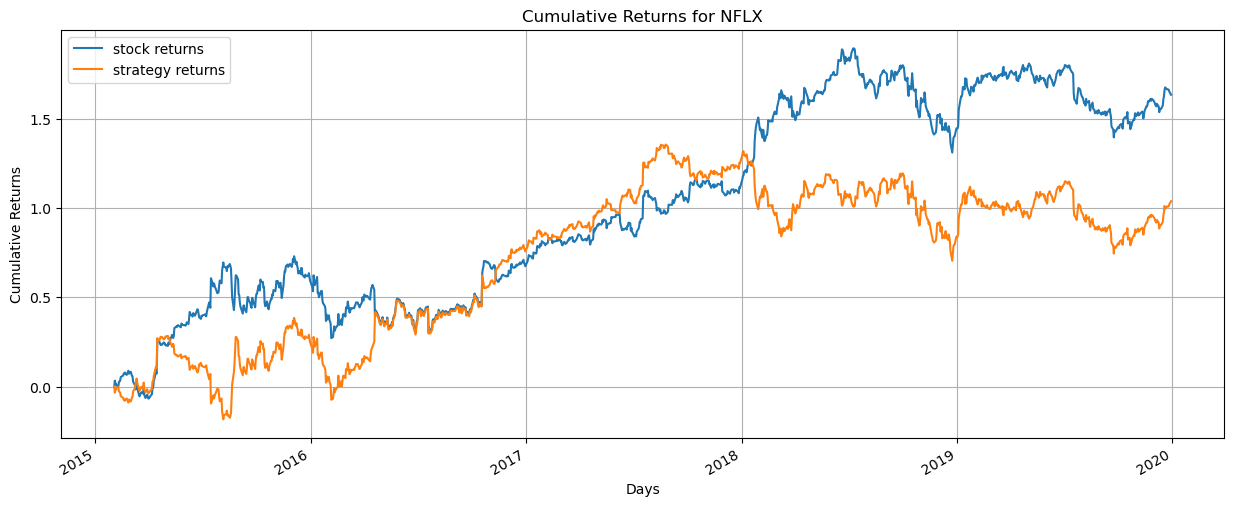

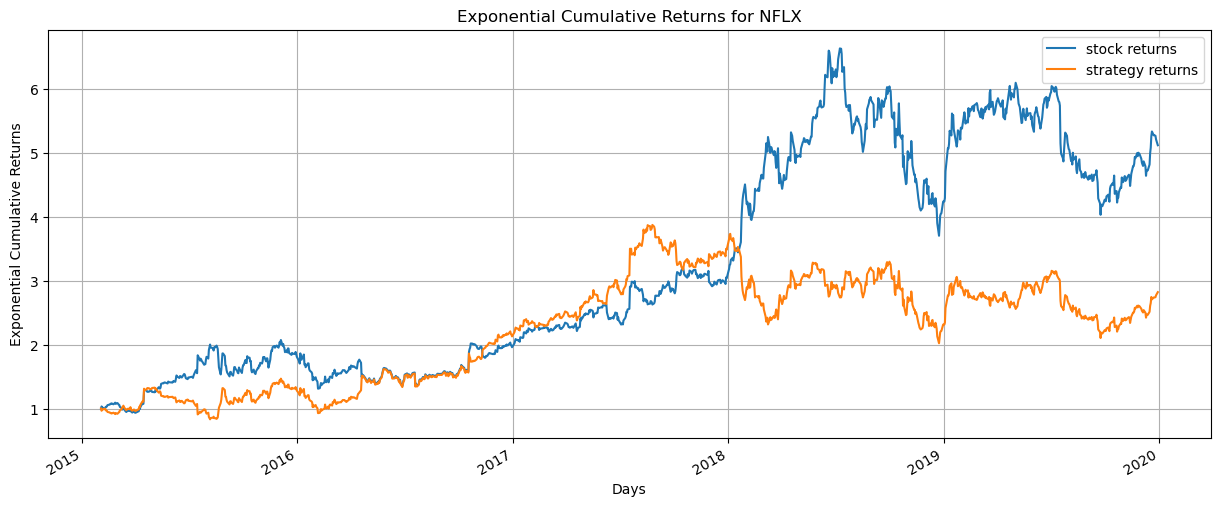

0.9131865953109373
Stock returns are 0.9131865953109384 for GOOGL
Strategy returns are 0.9561197609936306 for GOOGL
--------------------------


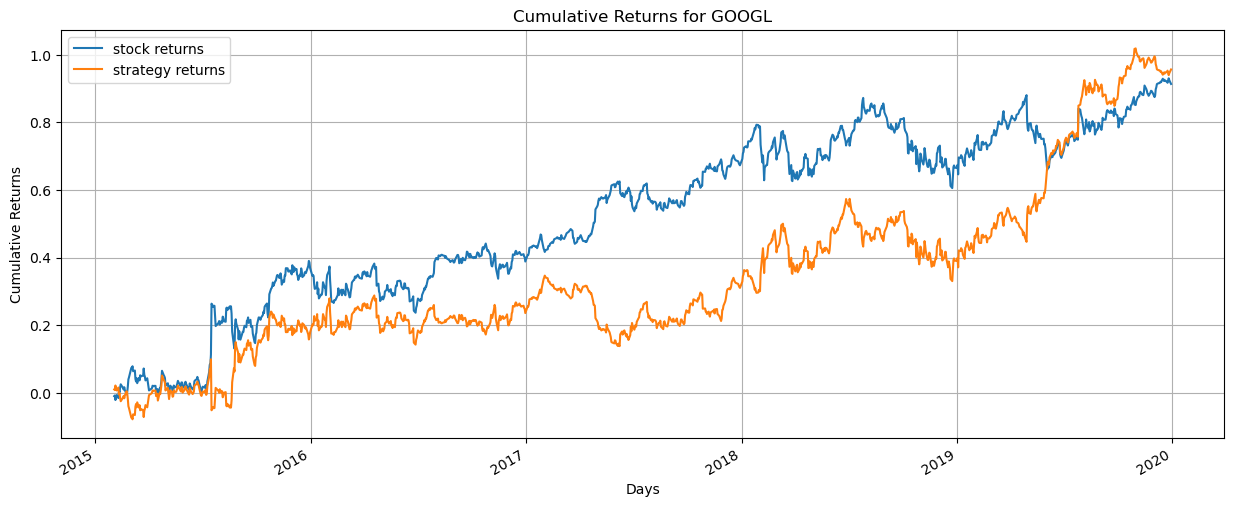

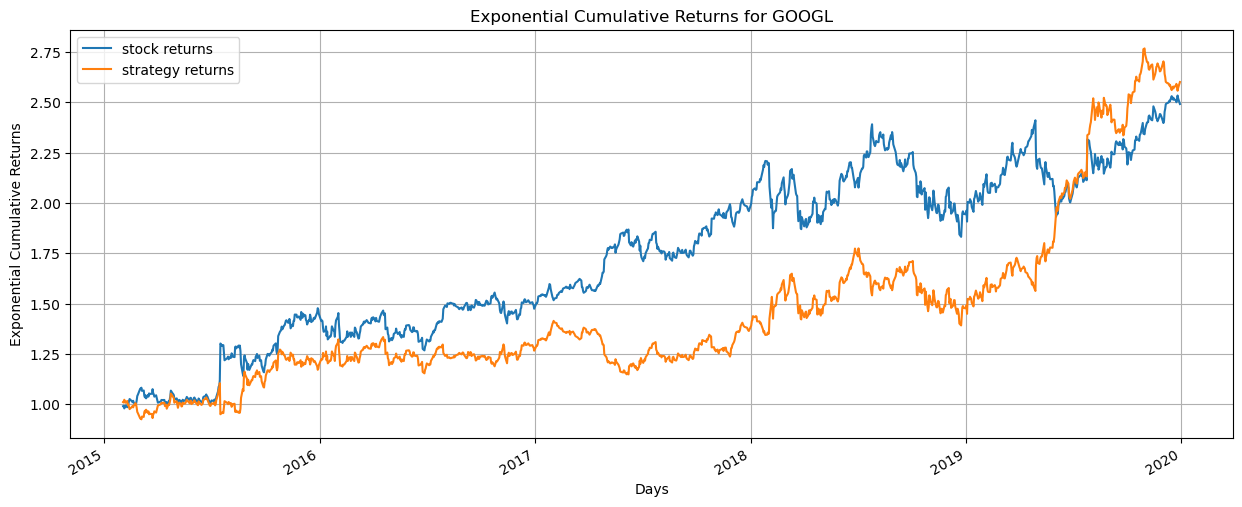

In [48]:
for stock in stockList:
    bt_data = stockList[stock]['backtest']['data']
    
    # Calculate stock returns
    stock_returns = bt_data['stock returns'].sum()
    print(stock_returns)

    # Logarithmic return calculation
    srd = np.log(bt_data["close price"].iloc[-1] / bt_data["close price"].iloc[0])
    print(f'Stock returns are {srd} for {stock}')

    # Calculate strategy returns
    bt_data["strategy returns"] = bt_data["stock returns"] * bt_data["position"].shift(1)
    strategy_returns = bt_data['strategy returns'].sum()
    print(f'Strategy returns are {strategy_returns} for {stock}')
    
    print('--------------------------')

    # Cumulative returns plot
    bt_data[["stock returns", "strategy returns"]].cumsum().plot(figsize=(15, 6))
    plt.title(f'Cumulative Returns for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()

    # Exponential of cumulative returns plot
    bt_data[["stock returns", "strategy returns"]].cumsum().apply(np.exp).plot(figsize=(15, 6))
    plt.title(f'Exponential Cumulative Returns for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Exponential Cumulative Returns")
    plt.grid()
    plt.show()



In [49]:
'''
Now since we have returns of both the Stock and the Strategy, We can calculate the risk return performance metrics

1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio

To convert log returns to regular returns:
Regular returns  = Exp(Log returns) - 1
Log Returns  = Ln(1 + Regular returns)

'''

for stock in stockList:
	bt_data = stockList[stock]['backtest']['data']

	# 1.  Annual Mean Returns or Expected returns
	daily_ret = bt_data[["stock returns", "strategy returns"]].mean()
	annual_ret =  daily_ret * 252
	#print( 'Annual log returns are: \n', annual_ret) # Note that these are the log returns

	# Convert back to regular returns
	# Due to the statistical challenges, we cannot perform calculations on gross returns,
	# Hence, we do that in log returns, and then convert back to regular

	annual_regular_ret = np.exp(annual_ret)-1
	print('Annual regular returns are: \n',annual_regular_ret)

	#2. Annual Standard deviation
	daily_std = bt_data[["stock returns", "strategy returns"]].std()
	annual_std =  daily_std * (252 **0.5)
	#print('Annual log std is: \n', annual_std) # Note that these are the log returns

	#Convert to regular
	daily_regular_std = (np.exp(bt_data[["stock returns", "strategy returns"]])-1).std()
	annual_regular_std =  daily_regular_std * (252 **0.5)
	print('Annual regular std is: \n', annual_regular_std) # Note that these are the log returns

	#3. Sharpe Ratio
	# Since we have already calculated the annual returns and risk we can use them

	sr = annual_regular_ret/ annual_regular_std
	print("The Sharpe Ratio is : \n ", sr)
	print('-----------------------------------')


Annual regular returns are: 
 stock returns       0.223603
strategy returns    0.214046
dtype: float64
Annual regular std is: 
 stock returns       0.282762
strategy returns    0.287504
dtype: float64
The Sharpe Ratio is : 
  stock returns       0.790779
strategy returns    0.744497
dtype: float64
-----------------------------------
Annual regular returns are: 
 stock returns       0.399662
strategy returns    0.051653
dtype: float64
Annual regular std is: 
 stock returns       0.286295
strategy returns    0.286308
dtype: float64
The Sharpe Ratio is : 
  stock returns       1.395978
strategy returns    0.180410
dtype: float64
-----------------------------------
Annual regular returns are: 
 stock returns       0.225014
strategy returns    0.053583
dtype: float64
Annual regular std is: 
 stock returns       0.245892
strategy returns    0.246436
dtype: float64
The Sharpe Ratio is : 
  stock returns       0.915091
strategy returns    0.217433
dtype: float64
-------------------------------

# <font color = 'red'> Records of results </font>

## polar attempt (worse for all)

The Sharpe Ratio is : 
  stock returns       0.790779
strategy returns    0.546036
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       1.395978
strategy returns   -0.103613
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.915091
strategy returns   -0.425270
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.963081
strategy returns   -0.097576
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.863143
strategy returns    0.339816
dtype: float64
-----------------------------------



## non-polar

The Sharpe Ratio is : 
  stock returns       0.790779
strategy returns    0.744497
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       1.395978
strategy returns    0.180410
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.915091
strategy returns    0.217433
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.963081
strategy returns    0.574920
dtype: float64
-----------------------------------
The Sharpe Ratio is : 
  stock returns       0.863143
strategy returns    0.915581
dtype: float64
-----------------------------------

<hr>

need to touch up below this

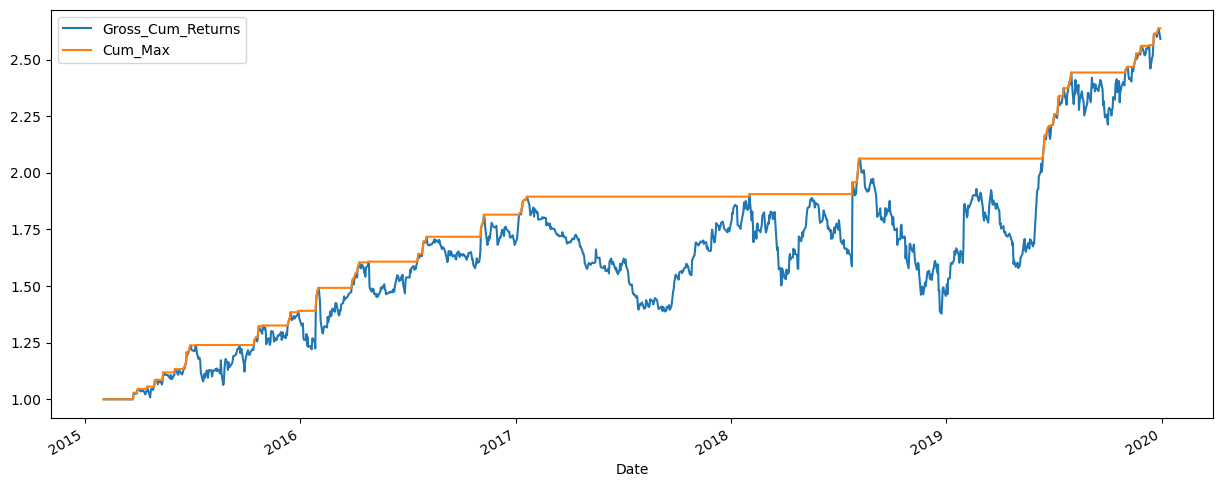

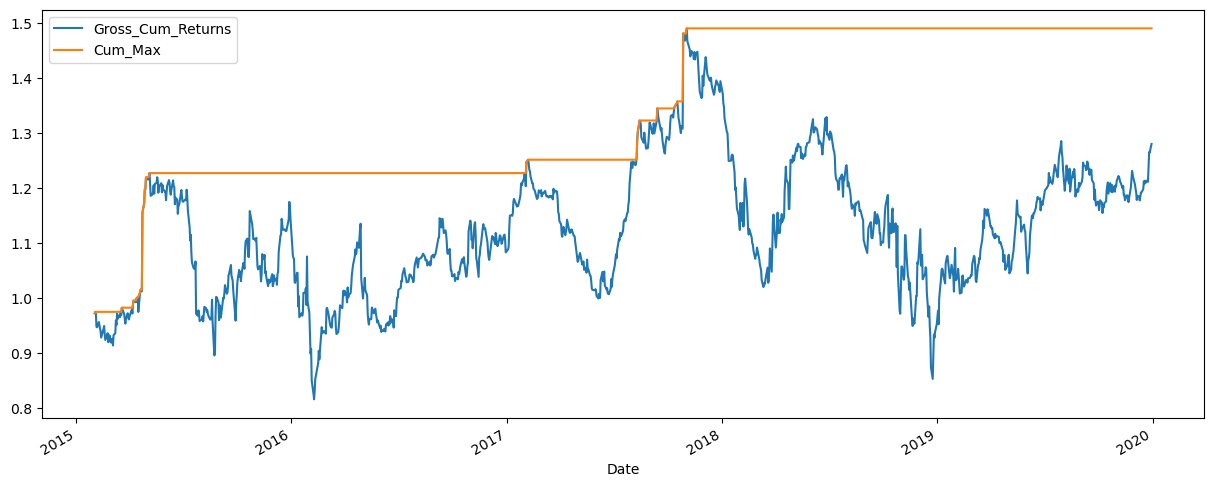

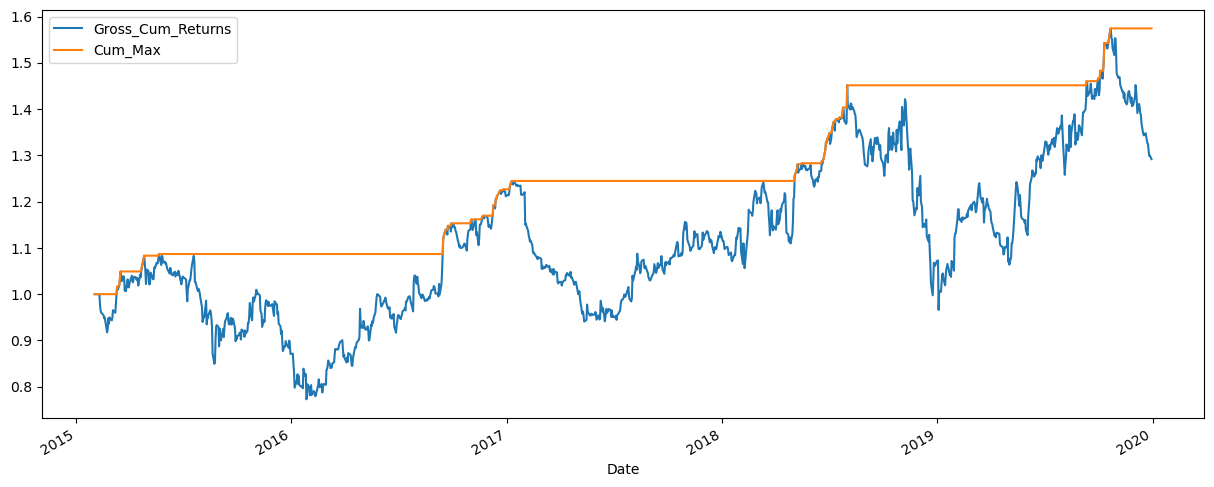

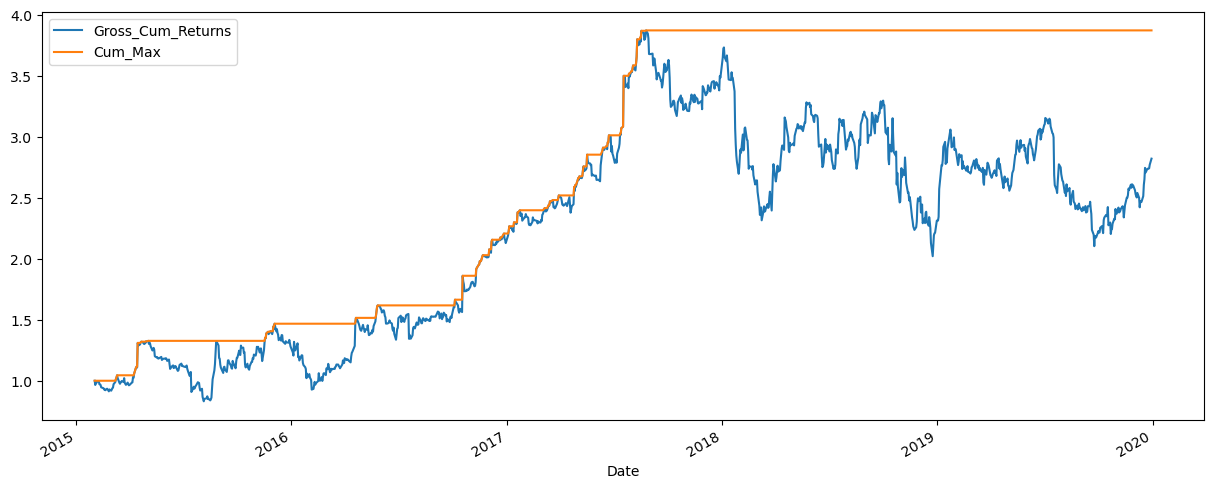

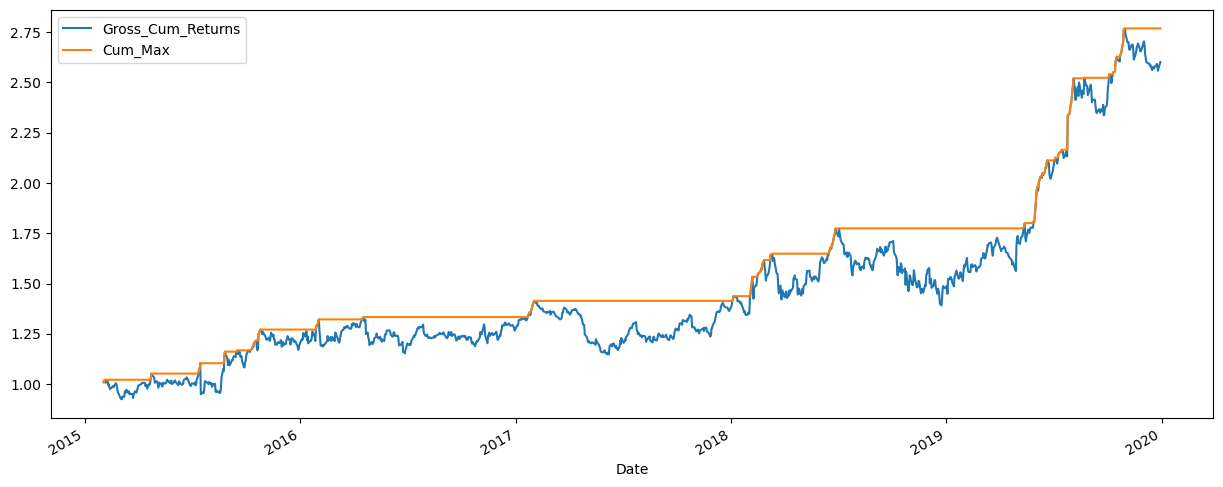

In [50]:
for stock in stockList:
	bt_data = stockList[stock]['backtest']['data']
	bt_data["Gross_Cum_Returns"] = bt_data["strategy returns"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
	bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()
	bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6))

# <font color = 'red'> Histogram of Daily Log Returns </font>

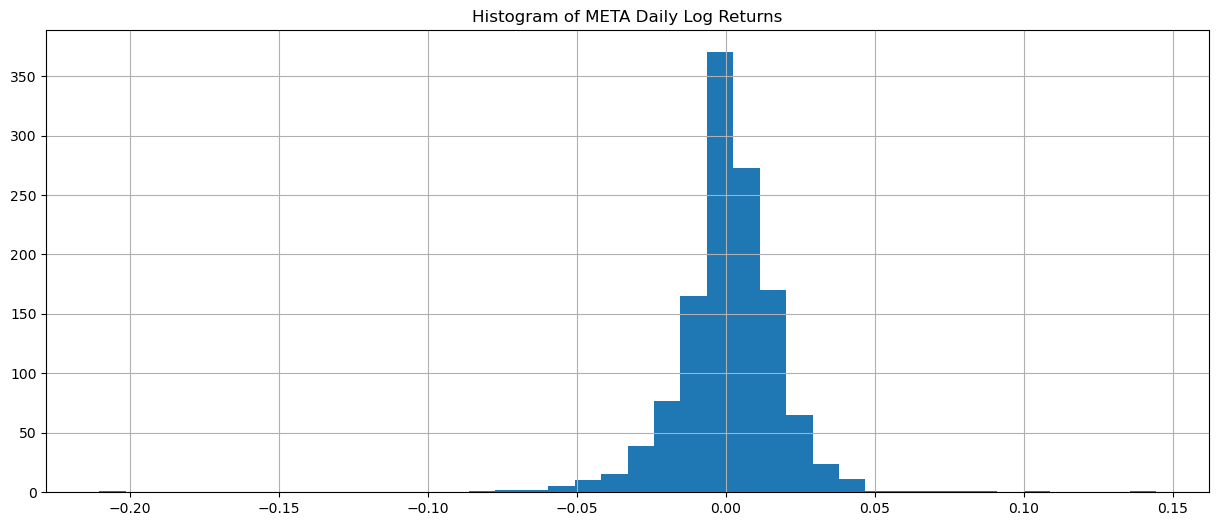

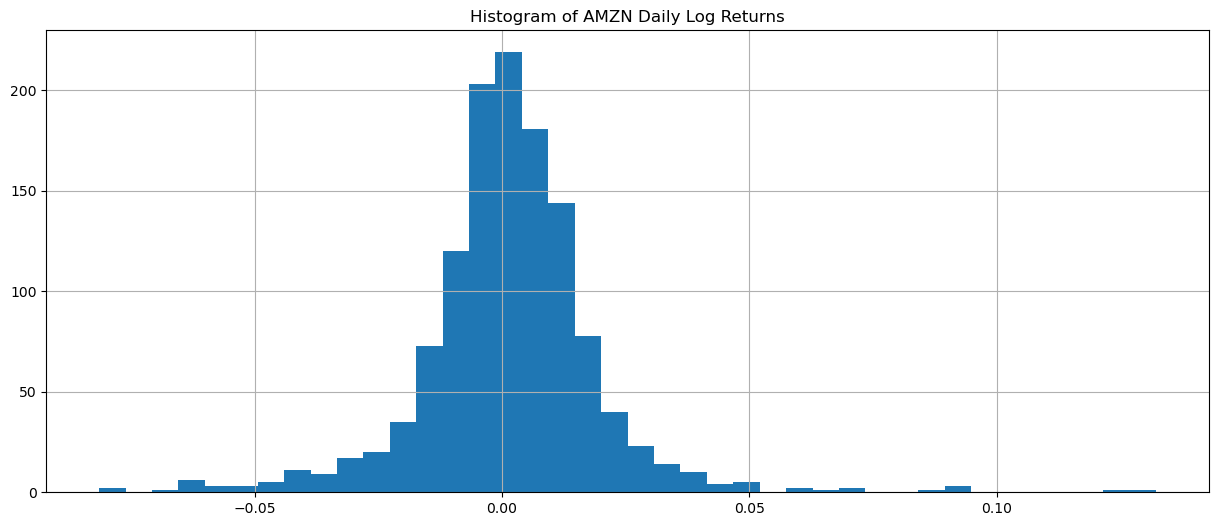

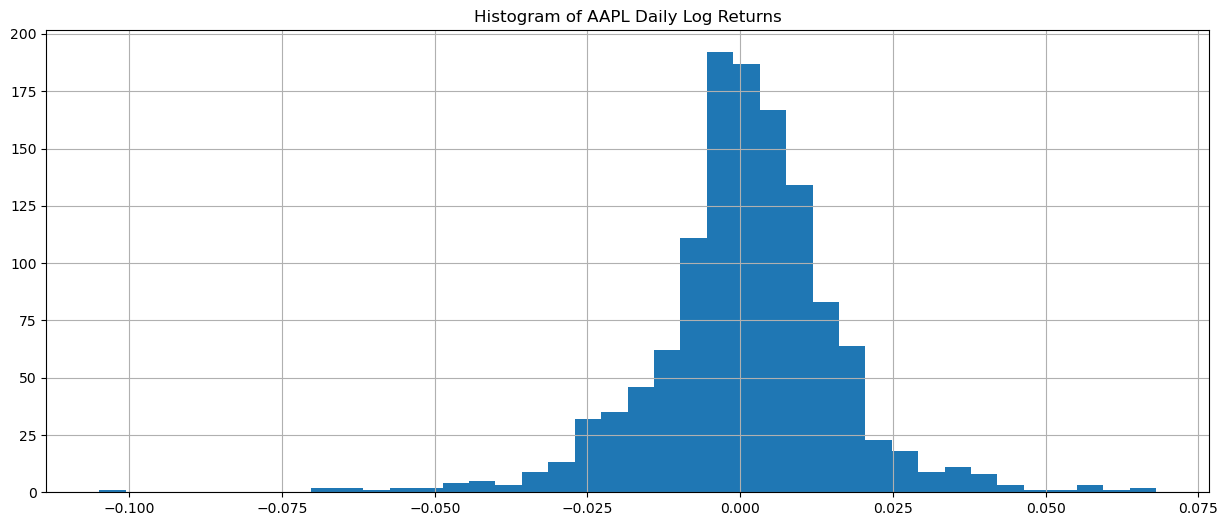

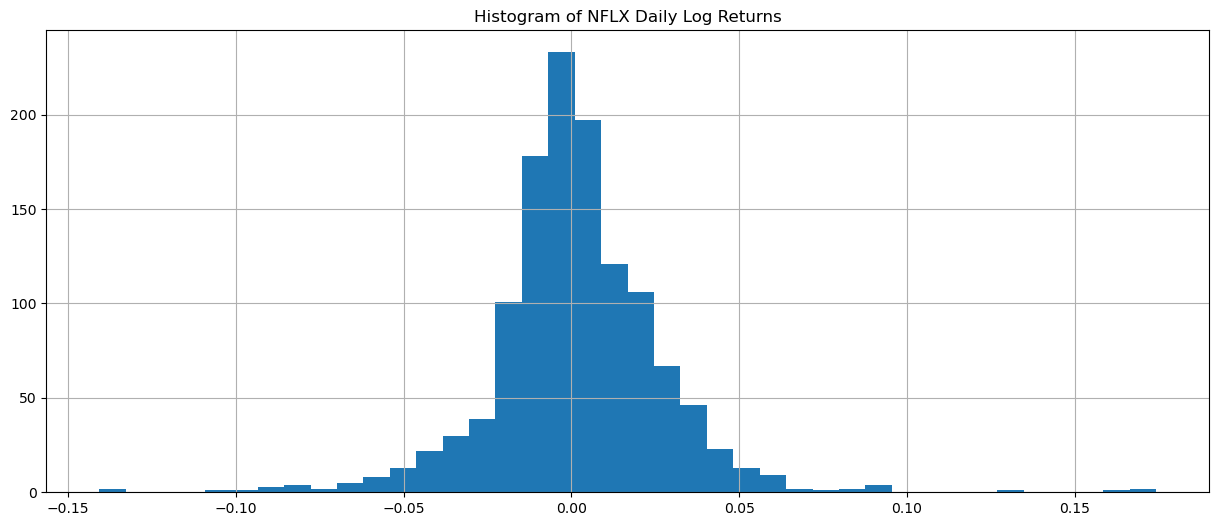

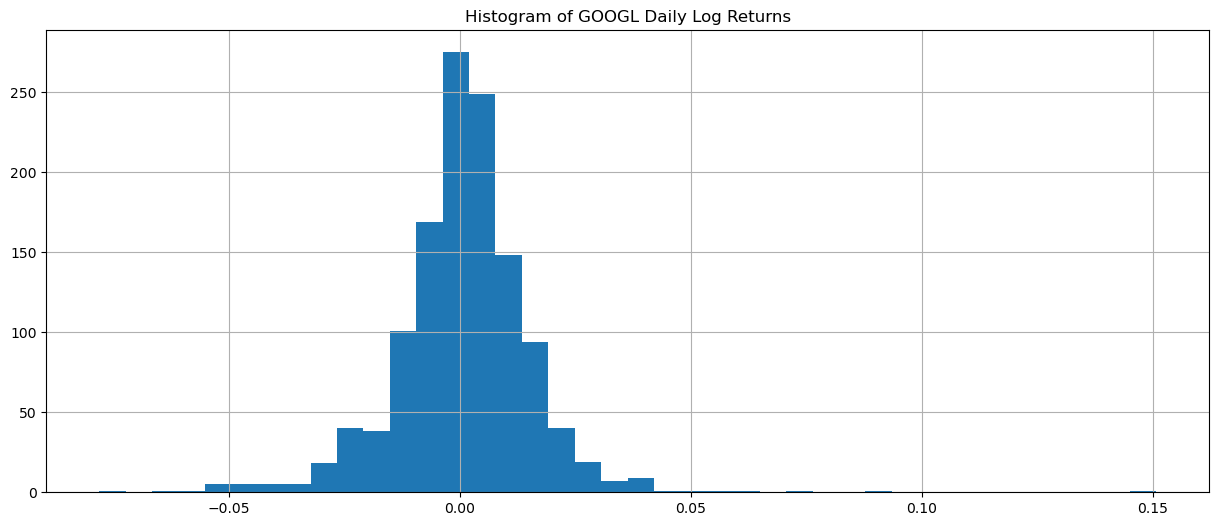

In [26]:
for stock in stockList:
	bt_data = stockList[stock]['backtest']['data']
	plt.figure(figsize=(15, 6))
	plt.hist(bt_data["stock returns"], bins = 40)
	plt.title(f"Histogram of {stock} Daily Log Returns")
	plt.grid()
	plt.show()

<hr>

Initial limitation and challenges
- combining 2 matrix --> decision of when to long, when to short
- ^on the same thread of thought, combining more than 2, exponential problem (could be solving using gridsearch or smthn)
- Binary decision of long/short --> I am referring to convertToPosition() fn --> I feel it is weid because not buying != short